Solving mushroom classification problem from https://github.com/pbiecek/InterpretableMachineLearning2020/issues/5

In [79]:
import numpy as np
import pandas as pd
import shap
import random
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

Load the data

In [118]:
data = pd.read_csv("dataset_24_mushroom.csv")
data.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,'x','s','n','t','p','f','c','n','k','e',...,'w','w','p','w','o','p','k','s','u','p'
1,'x','s','y','t','a','f','c','b','k','e',...,'w','w','p','w','o','p','n','n','g','e'
2,'b','s','w','t','l','f','c','b','n','e',...,'w','w','p','w','o','p','n','n','m','e'
3,'x','y','w','t','p','f','c','n','n','e',...,'w','w','p','w','o','p','k','s','u','p'
4,'x','s','g','f','n','f','w','b','k','t',...,'w','w','p','w','o','e','n','a','g','e'


In [119]:
data.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises%3F', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat', 'class'],
      dtype='object')

Target class is in column "class", "p" means poissonous, "e" means eatible. Let's preprocess the data: one-hot encode classes.

In [124]:
encoder = preprocessing.OneHotEncoder(sparse=False)
X = encoder.fit_transform(data.drop(columns=["class"]))
X = pd.DataFrame(X, columns=encoder.get_feature_names(data.columns.drop(["class"])))
y = np.array([0 if v == "'p'" else 1 for v in data["class"]])
print(X.shape)
print(len(y))
print("Eatable mushrooms: %d" % np.count_nonzero(y))

(8124, 117)
8124
Eatable mushrooms: 4208


Train and compute predictions for sample observations

In [134]:
classifier = RandomForestClassifier()
classifier.fit(X, y)
#indices = np.random.choice(X.shape[0], replace = False, size = 3)
indices = [470, 4676, 5145]
samples = X.iloc[indices]
print("Indices:")
print(indices)
print("Predictions:")
print(classifier.predict(samples))
print("Real labels:")
print(y[indices])

Indices:
[470, 4676, 5145]
Predictions:
[1 0 0]
Real labels:
[1 0 0]


Calculate SHAP values

In [137]:
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution
explainer = shap.Explainer(classifier.predict, X100)
shap_values = explainer(samples)

Plot SHAP values for sample observations

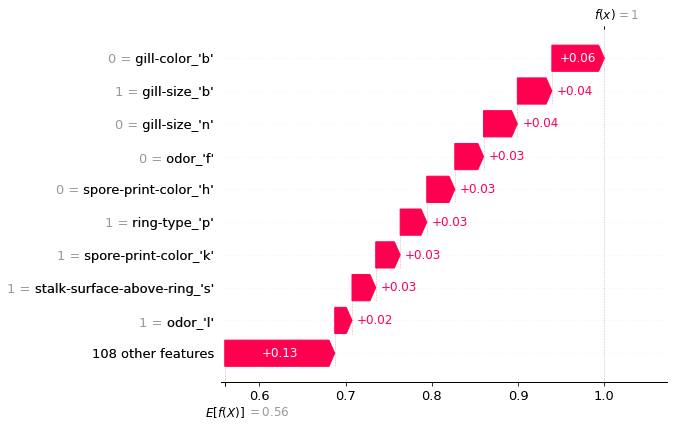

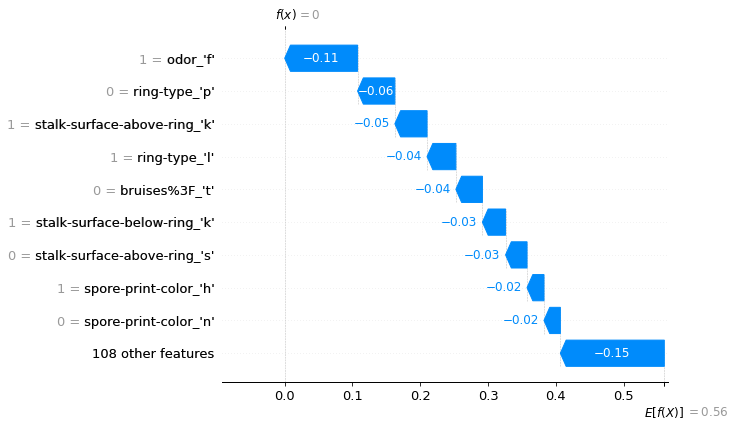

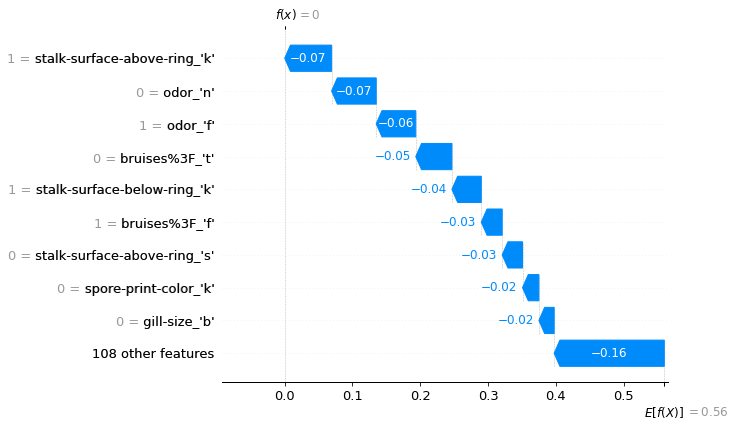

In [138]:
shap.plots.waterfall(shap_values[0], max_display=10)
shap.plots.waterfall(shap_values[1], max_display=10)
shap.plots.waterfall(shap_values[2], max_display=10)

As we see, the most important feature is different in every example above. Let's check if there exists feature that can contribute both positively and negatively for some samples.

In [155]:
#using tree algorithm to speed computations up
tree_explainer = shap.Explainer(classifier, X100, algorithm="tree")
values = tree_explainer(X)

100%|===================| 16199/16248 [01:11<00:00]        

In [186]:
print(values.values.shape)
is_any = False
for i in range(values.values.shape[1]):
    positive = np.sum(np.logical_and(X.to_numpy()[:,i] == 1, values.values[:,i,0] > 0))
    negative = np.sum(np.logical_and(X.to_numpy()[:,i] == 1, values.values[:,i,0] < 0))
    if (positive > 0 and negative > 0):
        print(X.columns[i])
        is_any = True
if (not is_any):
    print("There are no such columns")

(8124, 117, 2)
cap-shape_'b'
cap-shape_'f'
cap-shape_'k'
cap-shape_'x'
cap-surface_'s'
cap-surface_'y'
cap-color_'c'
cap-color_'e'
cap-color_'g'
cap-color_'n'
cap-color_'w'
cap-color_'y'
bruises%3F_'f'
bruises%3F_'t'
gill-spacing_'w'
gill-size_'b'
gill-color_'k'
gill-color_'p'
gill-color_'u'
gill-color_'w'
stalk-shape_'e'
stalk-shape_'t'
stalk-root_'b'
stalk-root_'c'
stalk-root_'e'
stalk-root_?
stalk-surface-above-ring_'f'
stalk-surface-above-ring_'s'
stalk-surface-above-ring_'y'
stalk-surface-below-ring_'f'
stalk-surface-below-ring_'s'
stalk-surface-below-ring_'y'
stalk-color-above-ring_'n'
stalk-color-above-ring_'w'
stalk-color-below-ring_'n'
stalk-color-below-ring_'w'
veil-color_'w'
ring-number_'o'
ring-number_'t'
ring-type_'e'
ring-type_'p'
spore-print-color_'h'
spore-print-color_'k'
spore-print-color_'w'
population_'c'
population_'s'
population_'v'
habitat_'d'
habitat_'g'
habitat_'l'
habitat_'u'


As we see, there are numerous such features. Let's test different model (logistic regression) and compare explanations:

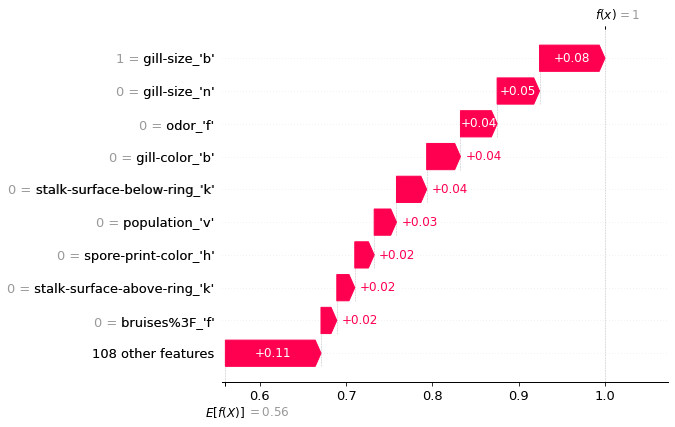

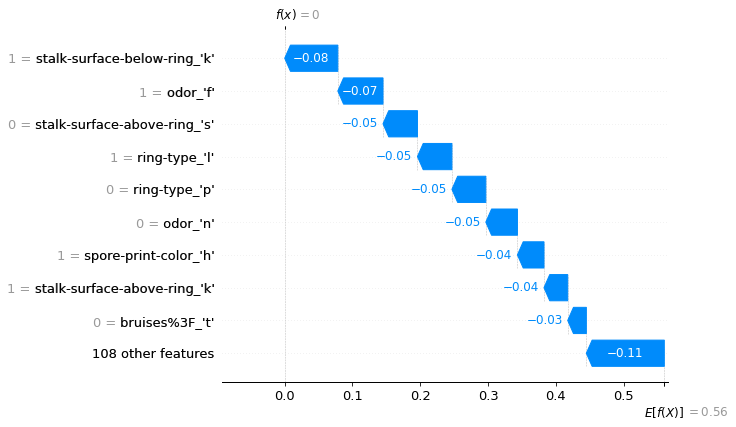

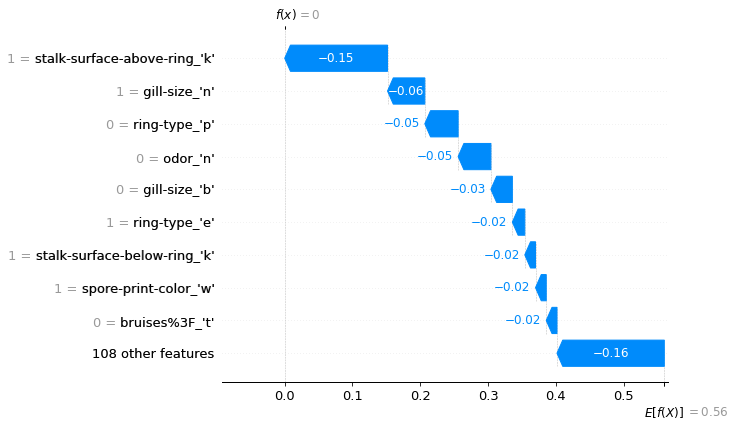

In [187]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X, y)
logistic_explainer = shap.Explainer(logistic_classifier.predict, X100)
logistic_values = explainer(samples)
shap.plots.waterfall(logistic_values[0], max_display=10)
shap.plots.waterfall(logistic_values[1], max_display=10)
shap.plots.waterfall(logistic_values[2], max_display=10)

As we see, attributions are different between models, but important features are similar (although the most important feature can still vary).

To sum up, it's clear that, there is no one most important feature according to SHAP. Furthermore, effect of many features can be both positive and negative, depending on other features. We also see that SHAP values depend on model that we use.

Those observations are a bit disturbing, because, as we've seen in previous homework, this dataset is very easy, almost any model solves it in 100%, and most cases can be explained by single features.